<a href="https://colab.research.google.com/github/MichaelBieri/Sequence-Forecast-Energy-Values-Stock-Prices-using-Multivariate-Analysis/blob/main/EnergyPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecast of energie tariff of a household with middle energy consumption H3 with including Stated Policies Scenario and APS (Announced Pledges Scenario), NZE (Net Zero Emissions by 2050 Scenario) for switzerland

In [ ]:
! git clone https://github.com/MichaelBieri/Sequence-Forecast-Energy-Values-Stock-Prices-using-Multivariate-Analysis.git

Cloning into 'Sequence-Forecast-Energy-Values-Stock-Prices-using-Multivariate-Analysis'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 41 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (41/41), 102.95 KiB | 780.00 KiB/s, done.
Resolving deltas: 100% (12/12), done.


# Model

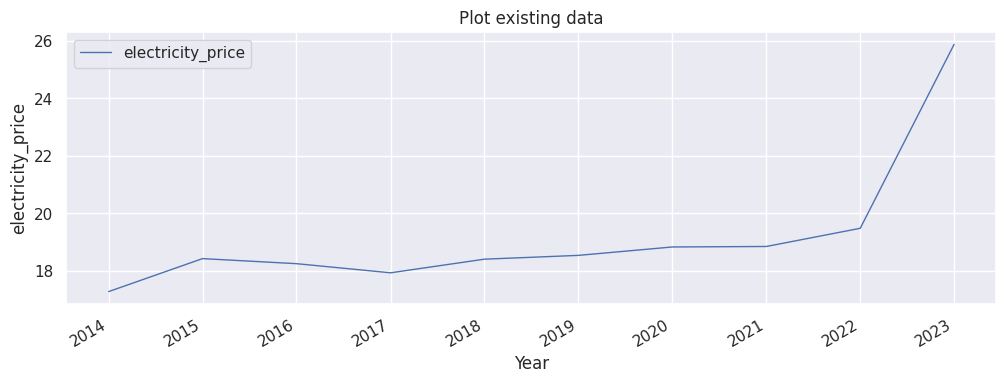

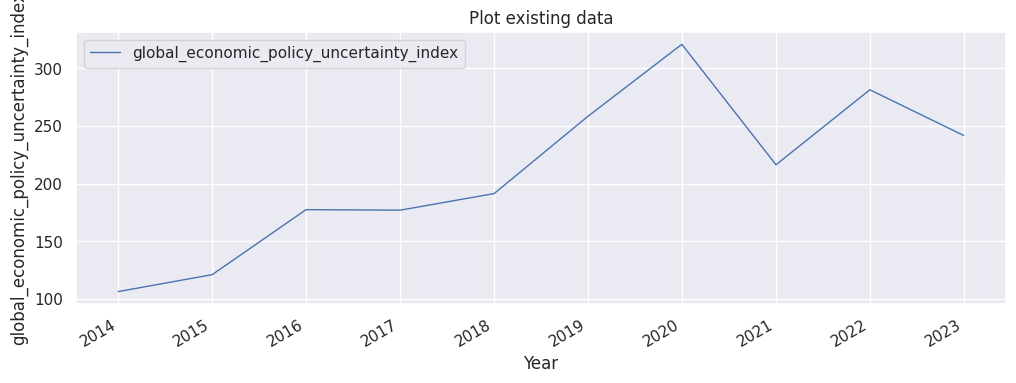

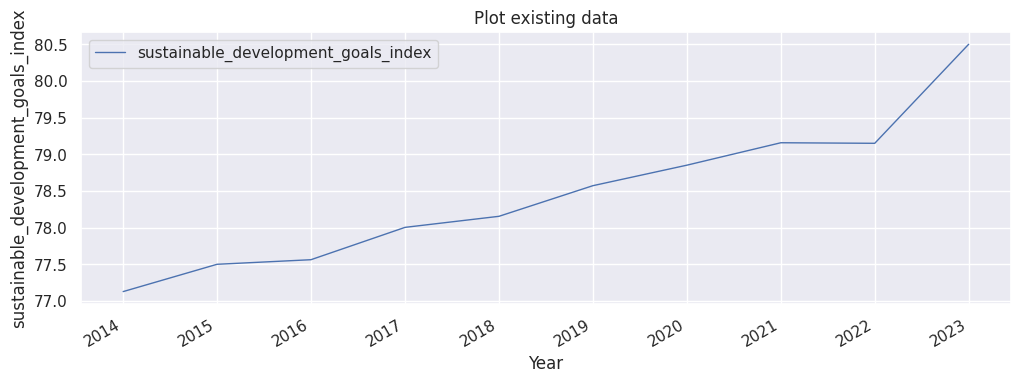

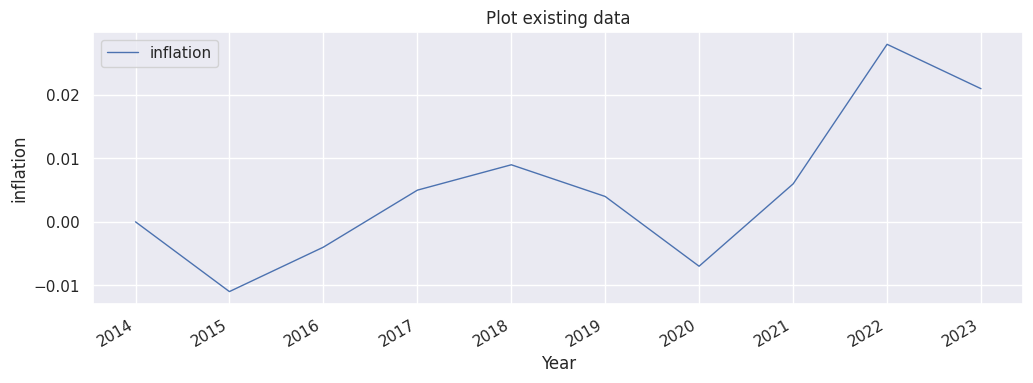

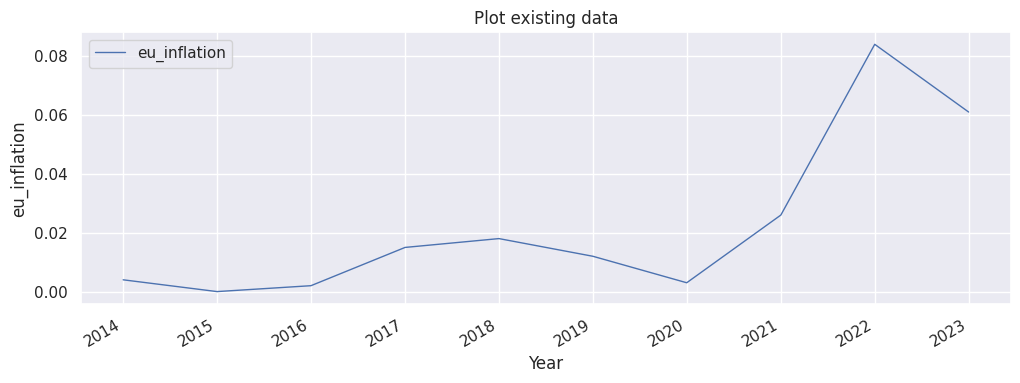

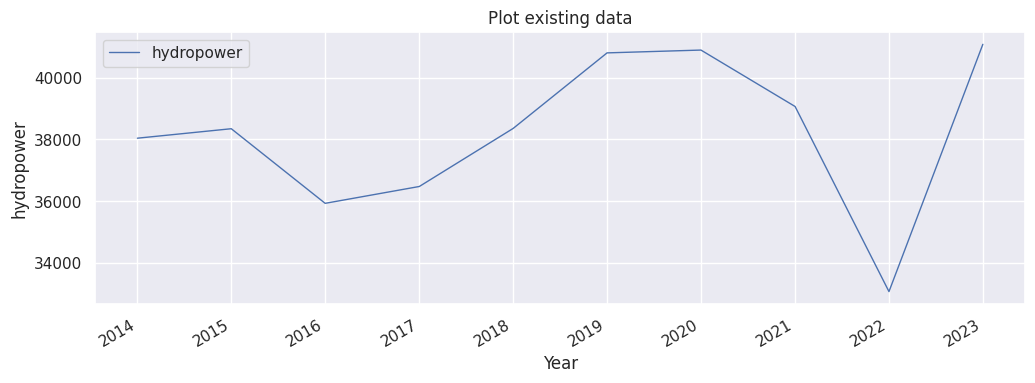

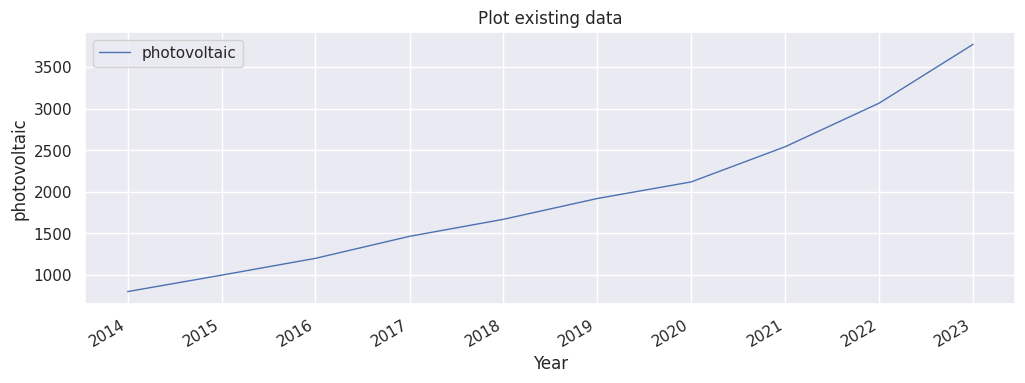

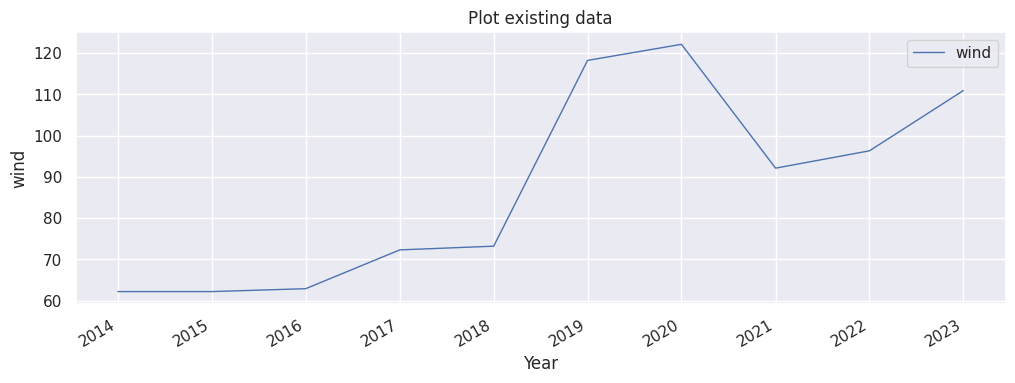

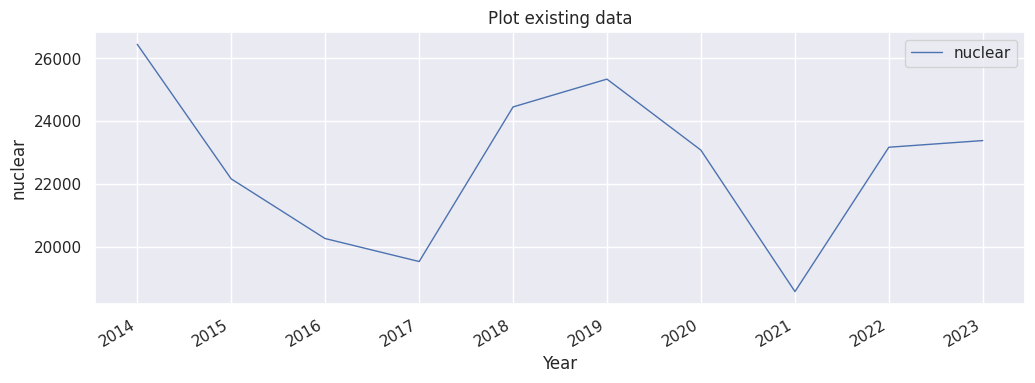

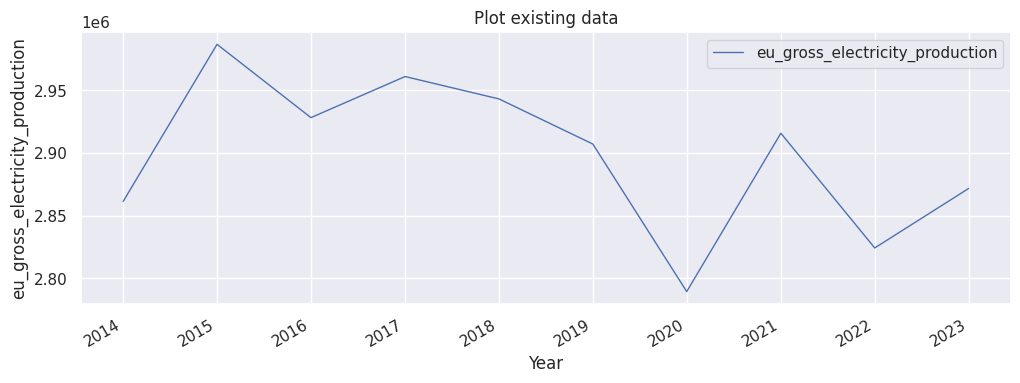

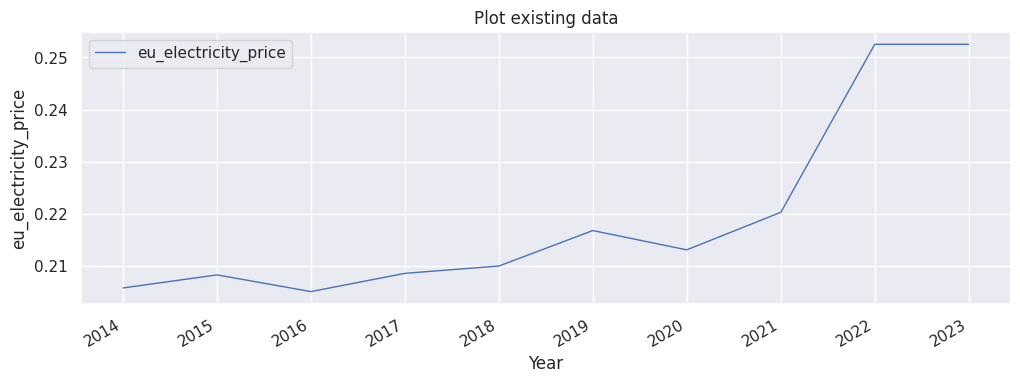

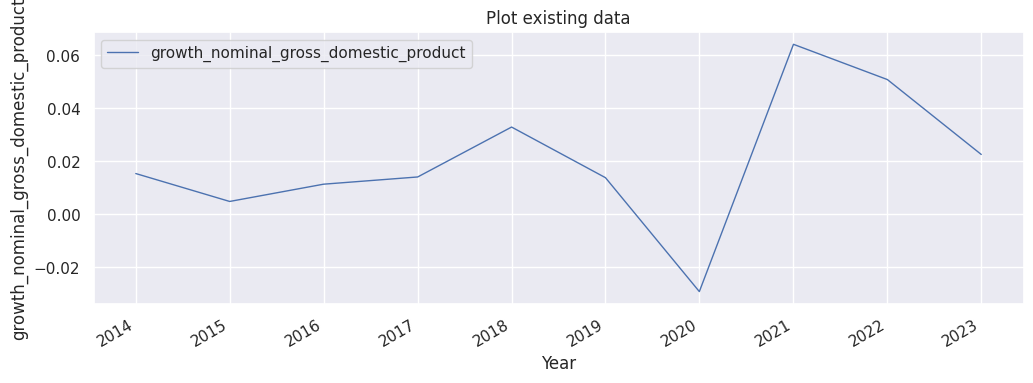

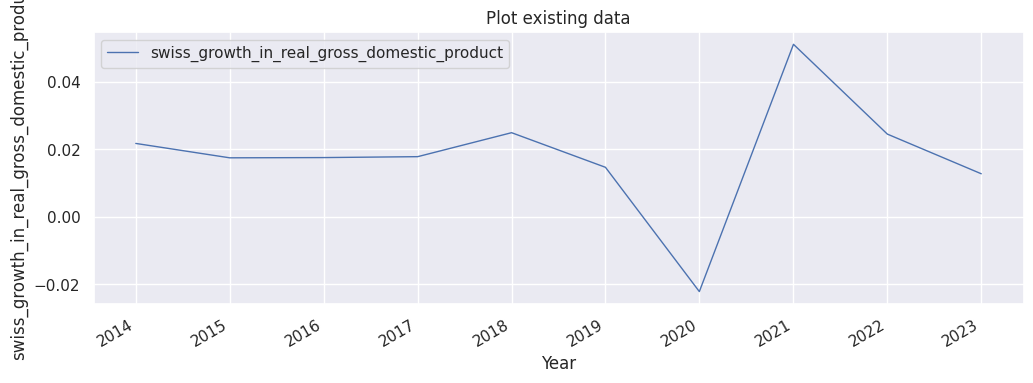

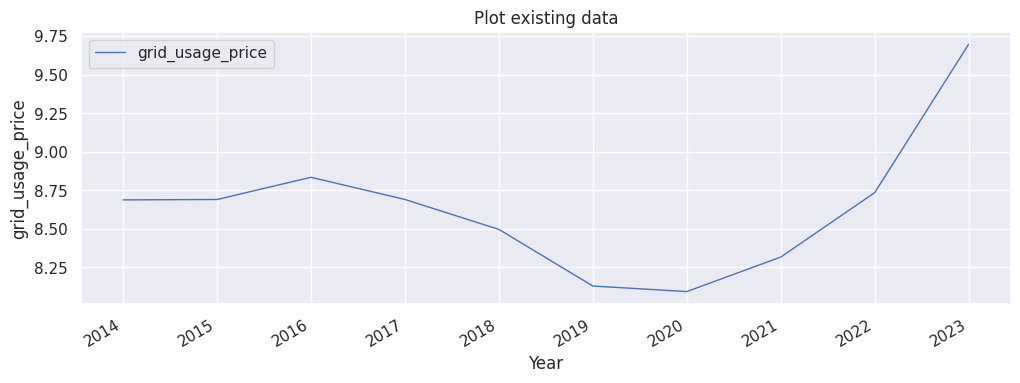

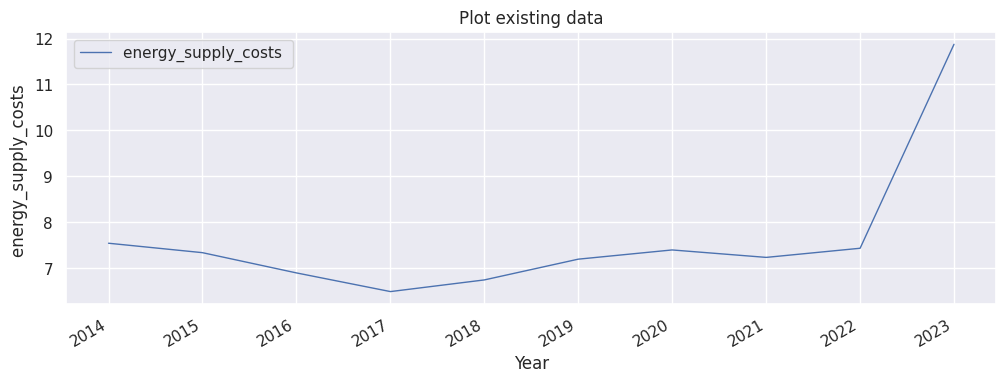

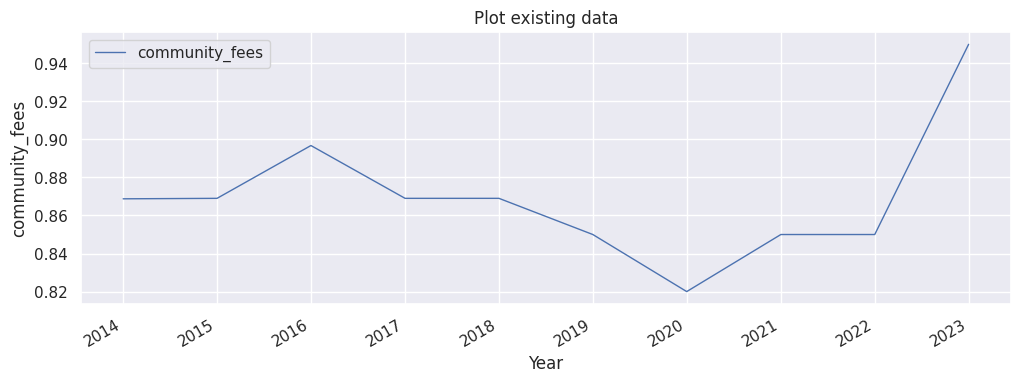

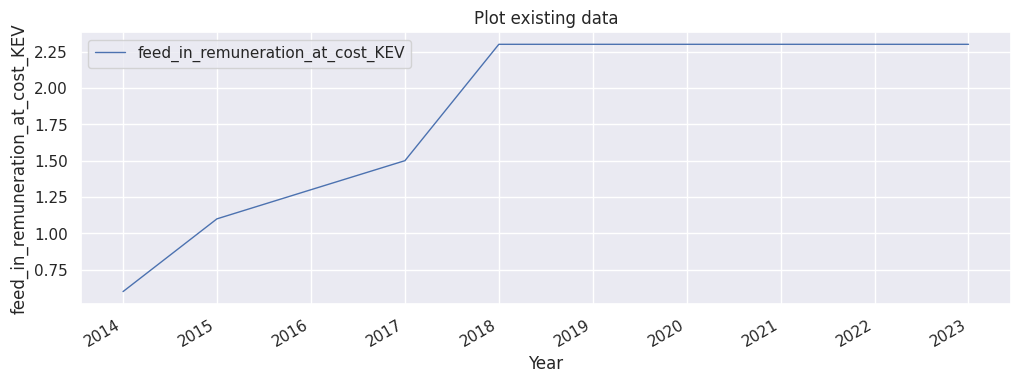

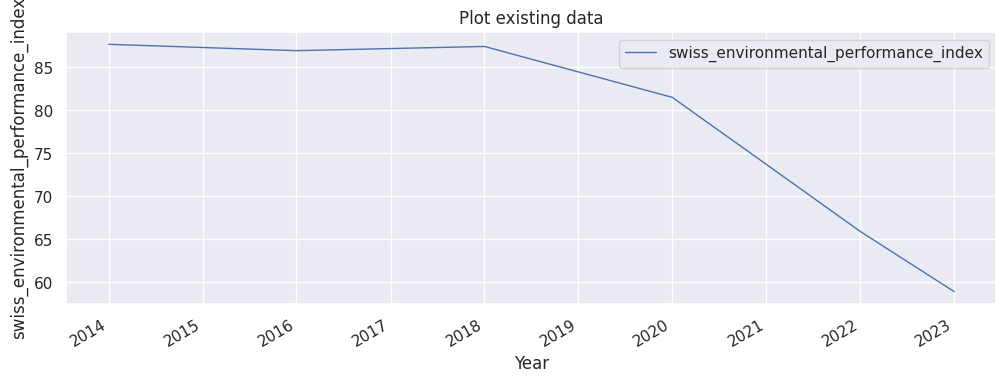

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 7, 5)              480       
                                                                 
 lstm_37 (LSTM)              (None, 5)                 220       
                                                                 
 dense_18 (Dense)            (None, 1)                 6         
                                                                 
Total params: 706 (2.76 KB)
Trainable params: 706 (2.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
1/1 - 10s - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.6138 - val_mean_squared_error: 0.6138 - 10s/epoch - 10s/step
Epoch 2/100
1/1 - 0s - loss: 0.2413 - mean_squared_error: 0.2413 - val_loss: 0.5912 - val_mean_squared_error: 0.5912 - 67ms/epoch - 67ms/step
Epoch 3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


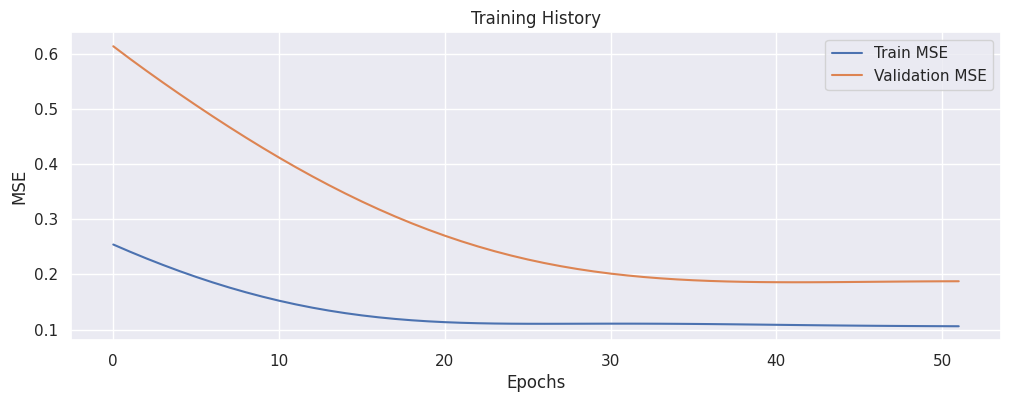

1/1 [==============================] - 1s 1s/step
   Predicted_Electricity_Price
0                    18.336771


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, CSVLogger
from typing import List

# Read and preprocess data
data = pd.read_csv('data.csv')
data = data.apply(pd.to_numeric, errors='coerce')

# Bootstrap function
def bootstrap(data: pd.DataFrame, n_bootstrap: int) -> list:
    bootstrap_samples = []
    for _ in range(n_bootstrap):
        sample_indices = np.random.randint(0, len(data), size=len(data))
        sample = data.iloc[sample_indices]
        bootstrap_samples.append(sample)
    return bootstrap_samples

# Perform Bootstrap Sampling
n_bootstrap = 3
bootstrap_samples = bootstrap(data, n_bootstrap)

concatenated_samples = pd.concat(bootstrap_samples, ignore_index=True)
concatenated_samples = concatenated_samples.sort_values(by='year', ascending=True)
concatenated_samples.to_csv('bootstrap_samples.csv', index=False)

# Merge files bootstrap_samples.csv and data.csv
df1 = pd.read_csv('data.csv')
df2 = pd.read_csv('bootstrap_samples.csv')
merged_df = pd.concat([df1, df2], ignore_index=True)
merged_df = merged_df.sort_values(by='year', ascending=True)
merged_df.to_csv('merged_data.csv', index=False)

# Read the merged data
data = pd.read_csv('merged_data.csv')

# Convert 'year' column to datetime format and set as index
data['year'] = pd.to_datetime(data['year'], errors='coerce', format='%Y')
data = data.dropna(subset=['year'])  # Drop rows where 'year' could not be converted
data.set_index('year', inplace=True)

# Plotting Einstellungen
sns.set(rc={'figure.figsize':(12, 4)})
sns.set_color_codes('bright')

# Plot all columns
for column in data.columns:
    ax = data[column].plot(linewidth=1, label=column)
    ax.set_title('Plot existing data')
    ax.set_xlabel('Year')
    ax.set_ylabel(column)
    plt.legend()
    plt.show()

# Split data
VALIDATION_SPLIT = 0.2
train_size = int(len(data) * (1 - VALIDATION_SPLIT))
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale train and test data
train_s = scaler.fit_transform(train)
test_s = scaler.transform(test)

# Fit the target scaler on the target column
target_scaler.fit(train.iloc[:, [0]])

# Function to create sequences for LSTM
timesteps_sequence = 7
def create_sequences(data, timesteps):
    X, Y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i])
        Y.append(data[i])
    return np.array(X), np.array(Y)

# Create sequences for training and testing
X_train, Y_train = create_sequences(train_s, timesteps_sequence)
X_test, Y_test = create_sequences(test_s, timesteps_sequence)

# LSTM model configuration
model = Sequential(name='sequential')
model.add(LSTM(units=5, input_shape=(timesteps_sequence, train_s.shape[1]), return_sequences=True))
model.add(LSTM(units=5))
model.add(Dense(units=1))
model.compile(optimizer="adam", loss="mse", metrics=['mean_squared_error'])

# Display model summary
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

# Early stopping and CSV logger callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
csv_logger = CSVLogger('training_log.csv', append=False, separator=';')

# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=VALIDATION_SPLIT, verbose=2, callbacks=[early_stopping, csv_logger])

# Save the model
model.save("model_energypriceprediction.h5")

# Plot training history
plt.plot(history.history['mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predict on the test data
Y_pred = model.predict(X_test)

# Rescale the predictions and true values
Y_test_rescaled = target_scaler.inverse_transform(Y_test)
Y_pred_rescaled = target_scaler.inverse_transform(Y_pred)

# Print the predicted values
predicted_df = pd.DataFrame(Y_pred_rescaled, columns=['Predicted_Electricity_Price'])
print(predicted_df)

